In [3]:
from sncosmo.utils import Result, Interp1D,ppf
import scipy
import numpy as np
import matplotlib.pyplot as plt

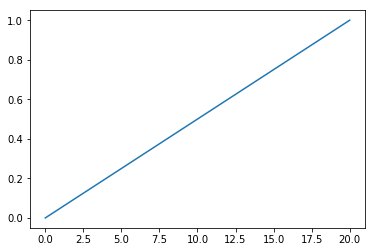

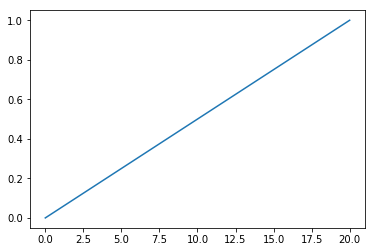

In [37]:
bounds={'v':(0,100),'g':(0,20)}
a,b=bounds['g']
x_samples = np.linspace(0., 1., 101)
#ppf_samples = ppf(bounds['g'], x_samples, a, b)
f = Interp1D(0., 1., np.array([a, b]))
f2=scipy.interpolate.interp1d([0.,1.],bounds['g'])
#plt.plot(x_samples[:-1],[f(x) for x in x_samples[:-1]])
data=np.array([f2(x) for x in x_samples])
plt.plot(data,x_samples)
plt.show()
data2=bounds['g']
p = 1. * np.arange(len(data2)) / (len(data2) - 1)
plt.plot(data2,p)
plt.show()

In [14]:
def prior_transform(u):
        d = {}
        for i in range(npdim):
            d[iparam_names[i]] = ppflist[i](u[i])
        v = np.empty(ndim, dtype=np.float)
        for i in range(ndim):
            key = vparam_names[i]
            v[i] = d[key]
        return v

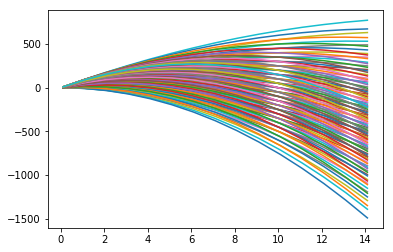

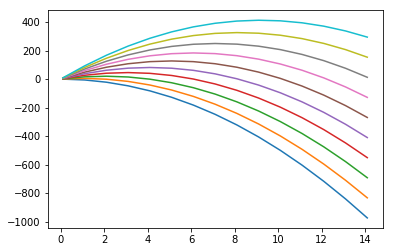

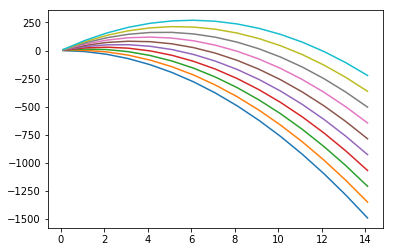

In [19]:
v1 = 50.
g1 = 9.8

def my_model( v,g, t):
    return v*t -.5*g*t**2
ts=np.arange(0.1,15,1)
for v in np.arange(0,100,10):
    for g in np.arange(5,15.3):
        plt.plot(ts,my_model(v,g,ts))
plt.show()

for v in np.arange(0,100,10):
    plt.plot(ts,my_model(v,9.8,ts))
plt.show()
for v in np.arange(0,100,10):
    plt.plot(ts,my_model(v,15,ts))
plt.show()

In [ ]:
v_tries = []
g_tries = []
chi_tries=[]
def callback(x):
    v_tries.append(x[0])
    g_tries.append(x[1])
    chi_tries.append(chisquare(x,my_args))
    

plt.plot(v_tries,chi_tries)
plt.show()
plt.plot(g_tries,chi_tries)
plt.show()

In [1]:
import numpy as np
import emcee

In [2]:

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [3]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [4]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [6]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))


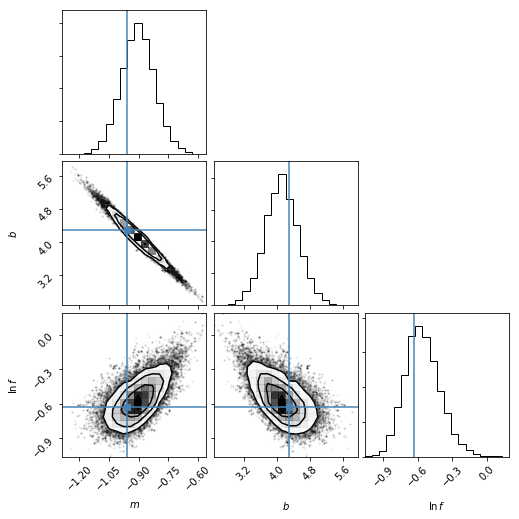

In [8]:
import corner
import matplotlib.pyplot as plt
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
plt.show()

<ErrorbarContainer object of 3 artists>

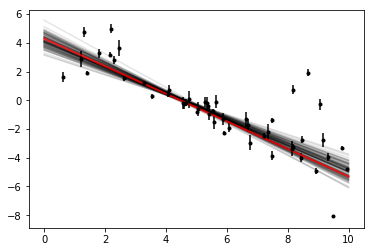

In [9]:
import matplotlib.pyplot as pl
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")

In [10]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))